In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml

%matplotlib inline

# MNIST

Получаем набор данных MNIST с помощью sklearn функции **fetch_openml**, возвращающая объект DataFrame по умолчанию. Поэтому, необходимо установить флаг **as_frame** в False.

In [2]:
X, y = fetch_openml('mnist_784', as_frame=False, return_X_y=True)

In [3]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

Состав MNIST - первые 60 тысяч **train** данных и остальные 10 тысяч **test** данных. При этом длина каждой строки - 784 пикселя, т.е. 28х28.

In [4]:
X.shape

(70000, 784)

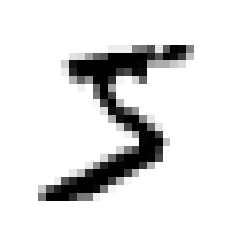

In [5]:
plt.imshow(X[0].reshape(28, 28), cmap=mpl.cm.binary)
plt.axis(False)
plt.show()

Так как **y** имеет строковый формат, преобразуем их в int.

In [6]:
y = y.astype(int)
y

array([5, 0, 4, ..., 4, 5, 6])

In [7]:
def draw_image(images, images_per_row=5):
    for index, image in enumerate(images):
        image = image.reshape(28, 28)
        n_rows = (len(images)-1) // images_per_row + 1
        plt.subplot(n_rows, images_per_row, index+1)
        plt.imshow(image, cmap=mpl.cm.binary)
        plt.axis(False)

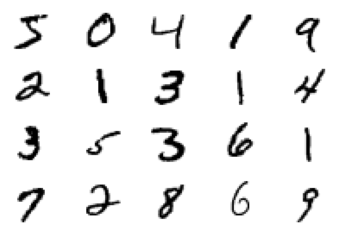

In [8]:
draw_image(X[:20])

In [9]:
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

# Бинарный классификатор

Создадим бинарный классификатор, оценивающий является ли число цифрой `1` или нет. Это делается для того, чтобы потом посмотреть как оценивать производительность классификатора.

In [10]:
y_train_1 = (y_train == 1).astype(int)
y_test_1 = (y_test == 1).astype(int)

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [12]:
clf = SGDClassifier()
clf.fit(X_train, y_train_1)

SGDClassifier()

In [13]:
cross_val_score(clf, X_train, y_train_1, cv=5, scoring='accuracy')

array([0.98816667, 0.97525   , 0.98933333, 0.98666667, 0.988     ])

Как можно заметить, модель довольно точно классифицирует единицу.

In [14]:
clf.predict(X[:20])

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

## Матрица ошибок

Создадим свой глупый классификатор, который будет говорить, что все классы не равны 1.

In [15]:
from sklearn.base import BaseEstimator

In [16]:
class Not1Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1))

In [17]:
not1_clf = Not1Classifier()
cross_val_score(not1_clf, X_train, y_train_1, cv=5, scoring='accuracy')

array([0.88741667, 0.88491667, 0.88491667, 0.88691667, 0.894     ])

Как можно заметить, точность почти 90%! Однако, такой классификатор не является точным абсолютно. Всё дело в том, что 9 из 10 цифр удовлетворяют условию "не единица" и именно поэтому точность такого классификатора почти 90%.

Поэтому очень часто для классификации применяют иные методы анализа. К примеру, матрицу неточностей.

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [19]:
pred = cross_val_predict(not1_clf, X_train, y_train_1, cv=5)

In [20]:
confusion_matrix(y_train_1, pred)

array([[53258,     0],
       [ 6742,     0]])

Как можно заметить, данный классификатор не определил ни один образец, как **положительный класс**.

Вспомним, что по горизонтали указаны **предсказанные классы**, а по вертикали - **фактические**. При этом, 1-й класс - **отрицательный**, 2-й - **положительный**.

In [21]:
pred = cross_val_predict(clf, X_train, y_train_1, cv=5)
confusion_matrix(y_train_1, pred)

array([[52694,   564],
       [  303,  6439]])

## Точность, полнота и F1

Выше продемонстрирован более справедливый классификатор, который определил положительный класс у 6 тысяч цифр, сделав ошибки 1-го и 2-го рода. Чтобы как-то оценить матрицу неточностей, существуют показатели **точности** и **полноты**, а также их среднее гармоническое - **f1** мера.

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [23]:
precision_score(y_train_1, pred)

0.9194630872483222

In [24]:
recall_score(y_train_1, pred)

0.9550578463363987

In [25]:
f1_score(y_train_1, pred)

0.9369225172790105

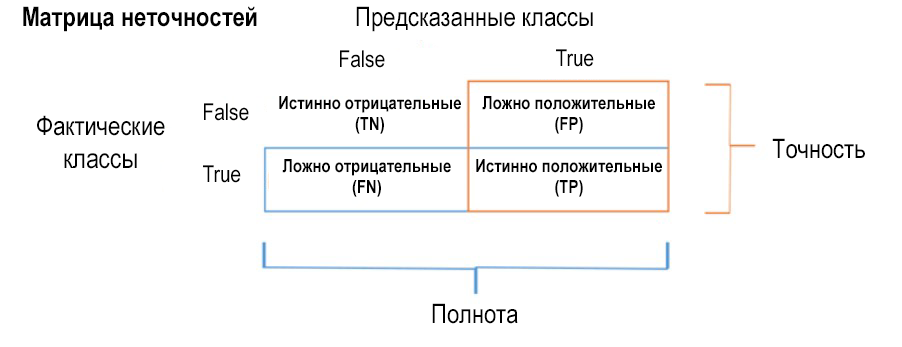

In [26]:
from IPython.display import Image
Image(data="./Confusion matrix.png")

Посмотрим теперь, как мы можем повлиять на границу принятия решения. Ниже представлено количество очков для цифры 1 и для цифры 9 соответственно. Выше показаны точность и полнота при стандартной границе.

In [27]:
clf.decision_function([X[3]]), clf.decision_function([X[4]])

(array([7120.08544899]), array([-19596.4947686]))

Попробуем изменить границу принятия решения и заметим, как изменятся показатели точности и полноты. Ровно так же для любой задачи можно изменить эти показатели в пользу б**о**льшей точности или полноты.

In [28]:
threshold = 4000
pred_new_threashold = (clf.decision_function(X_train) > threshold).astype(int)

In [29]:
precision_score(y_train_1, pred_new_threashold), recall_score(y_train_1, pred_new_threashold)

(0.9958167747333194, 0.7061702758825275)

Теперь нарисуем график точности-полноты с помощью **sklearn** и посмотрим как будут изменяться эти показатели при разных **границах** на графике.

In [30]:
from sklearn.metrics import precision_recall_curve

In [31]:
pred = cross_val_predict(clf, X_train, y_train_1, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_1, pred)

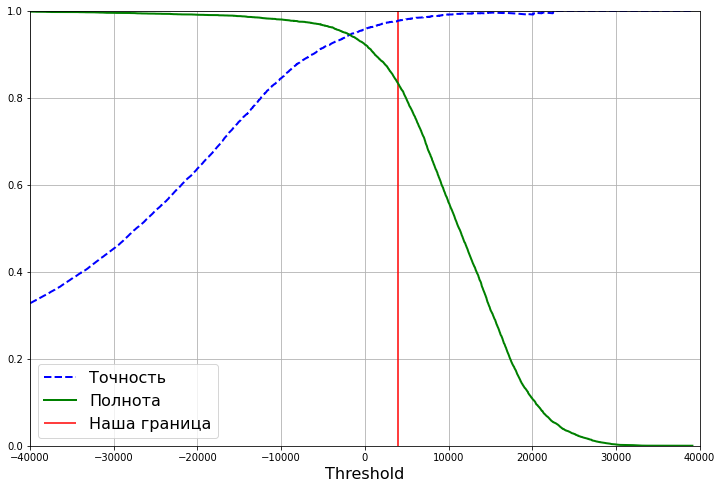

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b--", label="Точность", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Полнота", linewidth=2)
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([-40000, 40000, 0, 1])             
plt.vlines(threshold, 0, 1, color='red', label='Наша граница')
plt.legend(loc="lower left", fontsize=16)
plt.show()

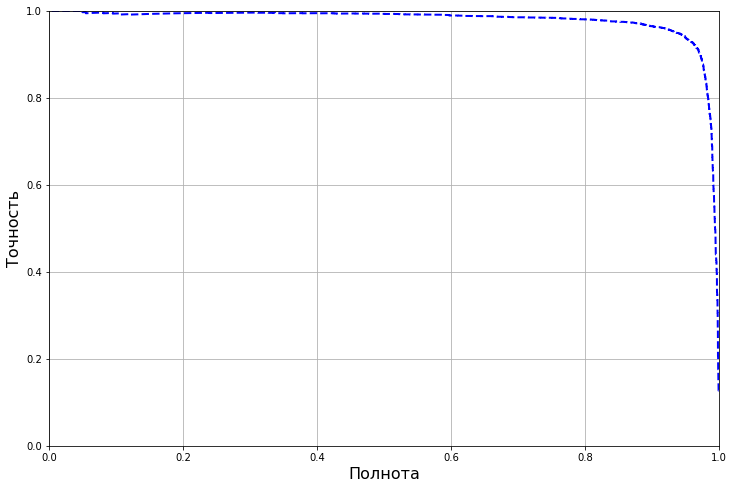

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(recalls, precisions, "b--", linewidth=2)
plt.xlabel("Полнота", fontsize=16)   
plt.ylabel("Точность", fontsize=16)        
plt.grid(True)                              
plt.axis([0, 1, 0, 1])             
plt.show()

Убедимся, что если мы выберем максимальную точность, то полнота будет ничтожно мала. Это и есть **компромисс точности-полноты**.

In [34]:
threshold = thresholds[np.argmax(precisions >= 0.99)]
threshold

9229.029434805136

**Примечание**: `np.argmax()` вернет первый индекс максимального значения в массиве.

In [35]:
y_train_pred_99 = (clf.decision_function(X_train) > threshold).astype(int)
precision_score(y_train_1, y_train_pred_99), recall_score(y_train_1, y_train_pred_99)

(0.9947916666666666, 0.028329872441412045)

## ROC

Чтоб ещё как-нибудь оценить качество классификации, используют ROC кривую.

In [36]:
from sklearn.metrics import roc_curve

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_1, pred)

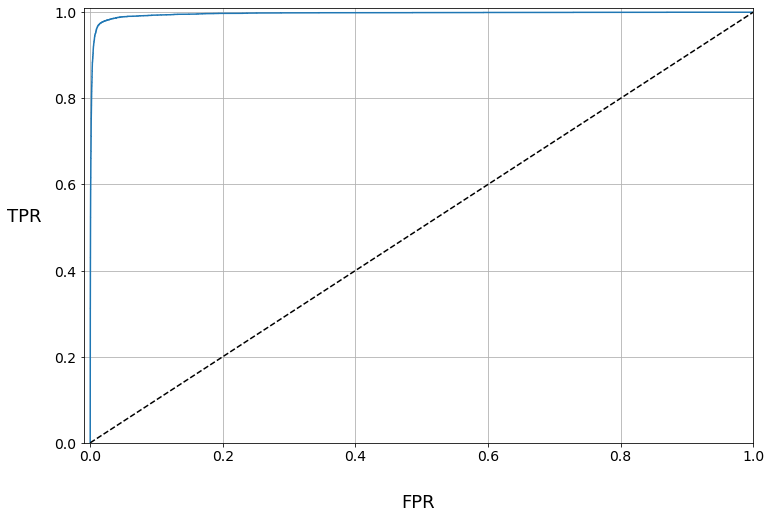

In [47]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
ax = plt.gca()
ax.tick_params(axis='both', labelsize=14)
plt.grid(True)
plt.xlabel('FPR', fontsize=18, labelpad=30)
plt.ylabel('TPR', fontsize=18, labelpad=30, rotation=0)
plt.axis([-0.01, 1, 0, 1.01])
plt.show()

Чтоб количественно оценить ROC кривую, используют показатель AUC (area under curve). Чем он больше (чем больше площадь под кривой), тем качественнее классификатор.

In [48]:
from sklearn.metrics import roc_auc_score

In [40]:
roc_auc_score(y_train_1, pred)

0.9963691938312882

На вопрос, что же лучше? Ответ довольно простой. Поскольку в данном классификаторе положительных классов **гораздо меньше**, то использовать необходимо **PR-кривую**. И на графике это заметно. ROC AUC буквально говорит, что классификатор идеален, однако PR-кривая говорит, что это не совсем так.

### RandomForest

Теперь сравним показатели с RandomForestClassifier.

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train_1)

RandomForestClassifier()

Поскольку RandomForest не имеет decision_function, мы не можем проделать всё, как до этого. Однако, по правилам, RandomForest должен иметь тогда функцию **predict_proba**, выдающая вероятность принадлежности конкретному классу (отрицательному или положительному). На основании этого и будет выводить соответствующий график PR.

In [43]:
y_probas_forest = cross_val_predict(forest, X_train, y_train_1, cv=3, method='predict_proba')

In [44]:
y_probas_scores = y_probas_forest[:, 1]

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_probas_scores)

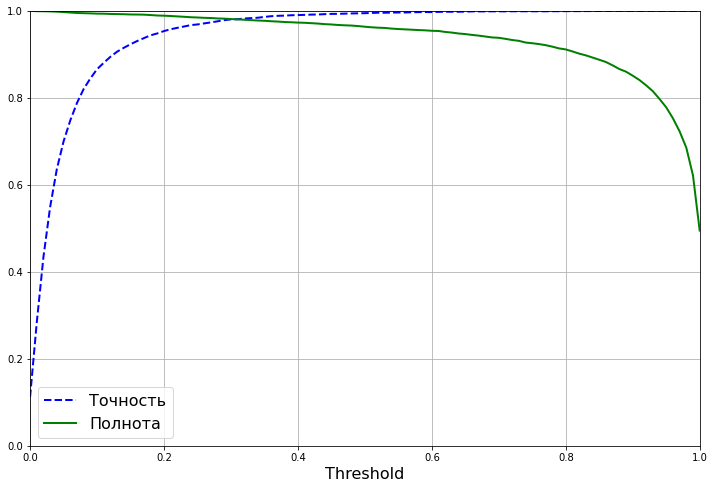

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b--", label="Точность", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Полнота", linewidth=2)
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([0, 1, 0, 1])             
plt.legend(loc="lower left", fontsize=16)
plt.show()

## Многоклассовая классификация

Рассмотрим многоклассовую классификацию и вспомним, что для многоклассовой классификации строятся несколько бинарных классификаторов (в случае, если алгоритмы - бинарны) с помощью стратегий OvO или OvR.

In [51]:
from sklearn.svm import SVC

In [52]:
svm = SVC()
svm.fit(X_train[:10000], y_train[:10000])

SVC()

Посмотрим, что для SVM (бинарный классификатор) `decision function` вычисляет количество очков для каждого класса на основе бинарных классификаторов.

In [53]:
svm.predict(X[:5])

array([5, 0, 4, 1, 9])

In [54]:
scores = svm.decision_function([X[0]])
scores

array([[ 0.73640179,  3.74695649,  6.22503198,  8.30364879, -0.30459674,
         9.30612304,  1.73376956,  3.76312093,  7.22128341,  3.7959883 ]])

In [55]:
np.argmax(scores)

5

## Анализ ошибок

Чтобы проанализировать ошибки классификатора, как и раньше, лучше всего использовать матрицу неточностей для многоклассовой классификации.

In [56]:
forest_preds = cross_val_predict(RandomForestClassifier(), X_train, y_train, cv=5, n_jobs=-1)

In [57]:
conf_matr = confusion_matrix(y_train, forest_preds)
conf_matr

array([[5843,    1,    7,    1,    5,    6,   17,    1,   37,    5],
       [   0, 6642,   35,   14,   11,    2,    6,   14,   14,    4],
       [  23,   13, 5764,   29,   25,    7,   21,   37,   31,    8],
       [   6,   11,   87, 5816,    2,   67,   12,   40,   60,   30],
       [  11,    9,   12,    1, 5660,    0,   26,   10,   17,   96],
       [  22,    7,    7,   61,   11, 5204,   50,    6,   27,   26],
       [  24,   10,    5,    0,   13,   43, 5805,    0,   17,    1],
       [   9,   19,   62,    7,   36,    1,    0, 6047,   12,   72],
       [   9,   28,   29,   45,   29,   42,   29,    4, 5577,   59],
       [  19,   11,   14,   77,   69,   15,    3,   51,   42, 5648]])

In [58]:
from sklearn.metrics import plot_confusion_matrix

In [59]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

Для отображения матрицы неточностей будет использоваться `plt.matshow`, являющаяся оболочкой над `plt.imshow`, устанавливающая некоторые настройки по-умолчанию, в частности, `interpolation='nearest'`, `aspect='equal'`

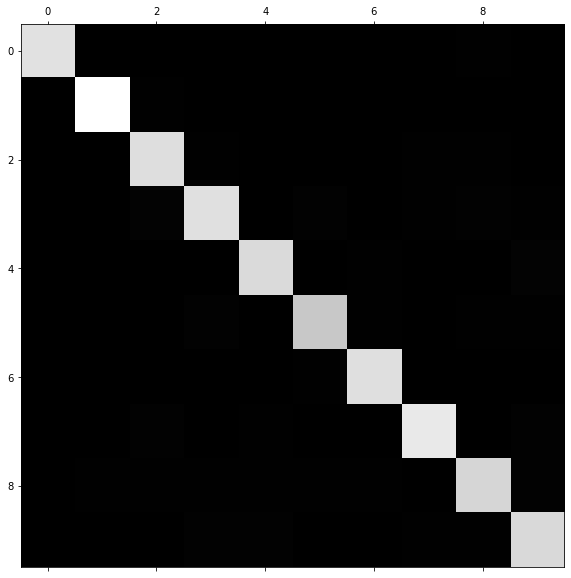

In [60]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.matshow(conf_matr, cmap=mpl.cm.gray)
plt.show()

Теперь необходимо нормализовать всю матрицу, поделив каждое значение в строке на сумму всех значений в фактическом классе. Это позволит сравнить нам частоту ошибок в каждом конкретном классе, а не абсолютное количество ошибок. При этом, заполним диагональ нулями, ведь диагональ означает, что ошибок совершено не было.

In [81]:
rows = conf_matr.sum(axis=1, keepdims=True)
normal_conf_matr = conf_matr / rows

In [82]:
normal_conf_matr.round(2)

array([[0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.95, 0.  , 0.01, 0.  , 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.96, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.97, 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.95, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.01, 0.95]])

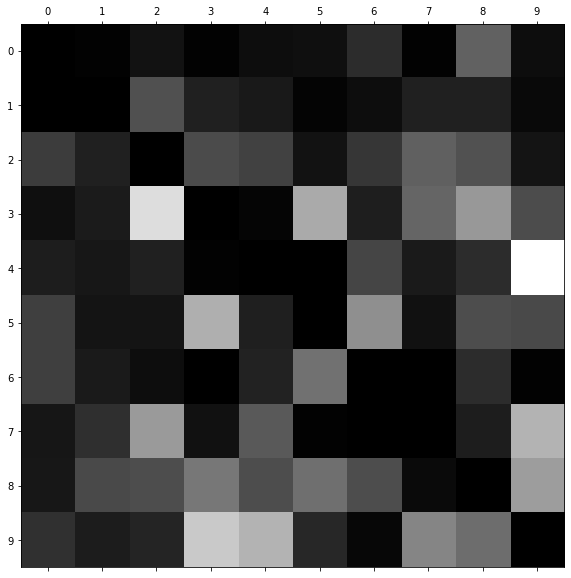

In [69]:
plt.figure(figsize=(10, 10))
np.fill_diagonal(normal_conf_matr, 0)
ax = plt.subplot(111)
ax.matshow(normal_conf_matr, cmap=mpl.cm.gray)
ax.set_xticks(range(0, 10))
ax.set_yticks(range(0, 10))
plt.show()

На матрице неточностей мы можем заметить, что классификатор путает фактическую тройку с двойкой. Давайте посмотрим, действительно ли их можно спутать.

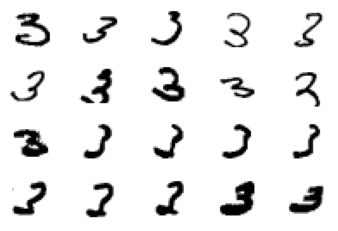

In [76]:
draw_image(X_train[(y_train == 3) & (forest_preds == 2)][:20])

То же самое активно происходит с четвёркой и девяткой.

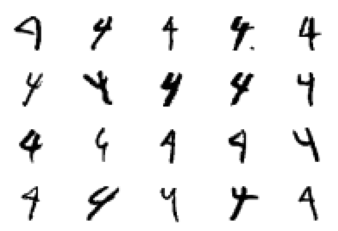

In [77]:
draw_image(X_train[(y_train == 4) & (forest_preds == 9)][:20])

Помочь исправить ошибки в классификаторе может проверка на то, повернута ли картинка, смещена ли. Либо, как ещё один из способов - это генерация датасета, путем смещения картинки на несколько пикселей по разным сторонам - **Data Augmentation**.

## Multilabel классификация

Создадим классификатор, идентифицирующий, какая это цифра, а также её чётность и делимость на 4. Обучим случайный лес на этом наборе и посмотрим вывод.

In [86]:
y_train_even = (y_train % 2 == 0)
y_train_mod_4 = (y_train % 4 == 0)
y_multilabel = np.c_[y_train, y_train_even, y_train_mod_4]
y_multilabel

array([[5, 0, 0],
       [0, 1, 1],
       [4, 1, 1],
       ...,
       [5, 0, 0],
       [6, 1, 0],
       [8, 1, 1]])

In [89]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X_train, y_multilabel)

RandomForestClassifier(n_jobs=-1)

In [91]:
forest.predict(X_test[:5])

array([[7, 0, 0],
       [2, 1, 0],
       [1, 0, 0],
       [0, 1, 1],
       [4, 1, 1]])

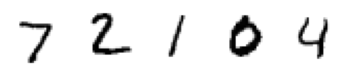

In [92]:
draw_image(X_test[:5])

Полная информация по поводу **multilabel** и иной классификации содержится в [официальной документации Scikit-Learn](https://scikit-learn.org/stable/modules/multiclass.html).

## Многовыходовая классификация

Итак, как стало понятно из всего вышеизложенного, всего существует 4 вида классификации:
* Бинарная классификация - когда вывод один, принимающий 0 или 1
* Многоклассовая классификация - когда вывод один, принимающий несколько значений
* Multilabel классификация - когда выводов несколько, принимающих 0 или 1
* Многовыходовая классификация - когда выводов несколько, принимающих несколько значений

В данном случае кратко рассмотрим последнюю, решив задачу по очистке изображения от шума.

Сначала создадим выборку, состоящая из набора пикселей цифр и некоторого шума.

In [112]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noised = X_train + noise

In [113]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noised = X_test + noise

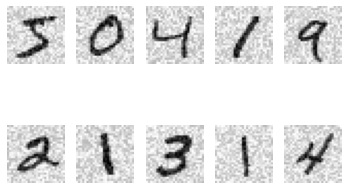

In [114]:
draw_image(X_train_noised[:10])

Значения, которые необходимо предсказать классификатору - первоначальные значения пикселей. На них и будет происходить обучение.

In [115]:
y_train_noised = X_train
y_test_noised = X_test

In [116]:
from sklearn.neighbors import KNeighborsClassifier

In [117]:
knn = KNeighborsClassifier()
knn.fit(X_train_noised, y_train_noised)

KNeighborsClassifier()

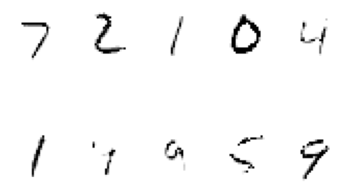

In [118]:
draw_image(knn.predict(X_test[:10]))

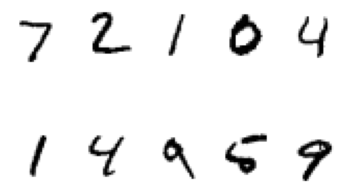

In [119]:
draw_image(X_test[:10])

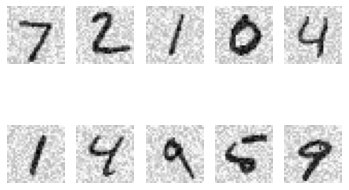

In [120]:
draw_image(X_test_noised[:10])